# Dynamic Bar Charts

In [1]:
import os
import re
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import networkx as nx
from networkx.algorithms import bipartite

from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

from nltk.stem import WordNetLemmatizer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [2]:
def clean_text(text, stop_words, lemmatizer):
    """
    Preprocess the text using lemmatization.
    """
    text = text.casefold()
    text_list = [
        lemmatizer.lemmatize(word)
        for word in re.findall(r'\b[a-z-]+\b', text)
        if word not in stop_words
    ]
    return ' '.join(text_list)

def vectorize(corpus, model, params):
    """
    Vectorize the corpus of articles using `model`.
    """
    vectorizer = model(**params)
    sparse_corpus = vectorizer.fit_transform(corpus)
    corpus_df = pd.DataFrame.sparse.from_spmatrix(
        sparse_corpus, columns=vectorizer.get_feature_names_out()
    )
    return corpus_df

def get_token_counts(df):
    """
    Return a series of the sum of weights of each token in the TF-IDF
    vectorized corpus.
    """
    return df.sum().sort_values(ascending=False)

## Topics

In [3]:
data_path = ('../data/'
             'df-rappler-ner-sentiment-content-timestep.csv')
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])

df.dropna(subset=['content.rendered'], inplace=True)

In [4]:
window_size = 7
step_length = 1
#----------------------
articles_by_date = (
    df
    .set_index('date')
    .resample('D')['id']
    .apply(list)
)

rolling_articles = articles_by_date.rolling(
    window=window_size,
    closed='right',
    step=step_length
)

indices_by_window = pd.Series([window.sum() for window in rolling_articles])
indices_by_window.index = indices_by_window.index + 1
indices_by_window.index.name = 'timestep'
indices_by_window.name = 'articles'

In [5]:
# Define the list of stopwords
stop_words = list(
    set(stopwords.words('english') + list(STOPWORDS) + ['let'] +
    [
        'said', 'nbsp', 'told', 'one', 'two', 'three', 'four', 'five', 'last',
        'january', 'february', 'march', 'april', 'may', 'june', 'july',
        'august', 'september', 'october', 'november', 'december', 'year',
        'quarter', 'month', 'week', 'day',
        'price', 'company', 'business', 'rate', 'new'
    ])
)

# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the parameters of TfidfVectorizer
bow_params = dict(
    ngram_range=(1, 2),
    token_pattern=r'[a-z-]{2,}',
    stop_words=stop_words,
    max_df=0.95,
    min_df=0.05,
    max_features=None
)

In [6]:
clean_content = (
    df
    .set_index('id')['content.rendered']
    .sort_index()
    .apply(lambda x: clean_text(x, stop_words, lemmatizer))
)

corpus = vectorize(clean_content, CountVectorizer, bow_params)
corpus.index = clean_content.index

tokens = get_token_counts(corpus)

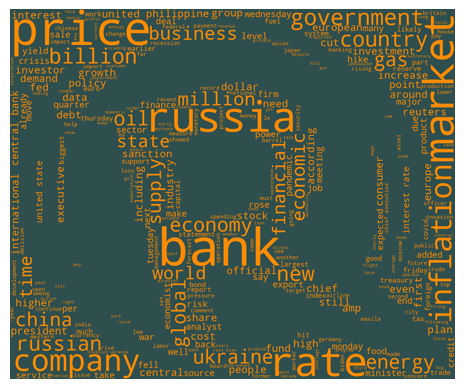

In [12]:
def color_func(*args, **kwargs):
    return 'darkorange'

mask = np.array(Image.open('rappler.png'))

wc = WordCloud(
    mask=mask,
    background_color='darkslategray',
    max_words=300,
    color_func=color_func,
    collocations=False,
    stopwords=stop_words,
    random_state=1337,
)

plt.imshow(wc.generate_from_frequencies(tokens), interpolation='spline16')
plt.axis('off')
plt.savefig('rappler-cloud.png', dpi=300)

In [11]:
tokens.head(10).index

Index(['bank', 'market', 'russia', 'inflation', 'government', 'country',
       'billion', 'russian', 'oil', 'economy'],
      dtype='object')

In [8]:
corpus

,-billion,-year,-year-old,ability,able,access,according,account,across,act,...,worried,worry,worst,worth,wrote,yen,yet,yield,york,york usa
id,,,,,,,,,,,,,,,,,,,,,
1542619,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1543036,1,0,0,0,0,0,1,0,0,0,...,0,0,3,0,0,0,0,1,0,0
1543064,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1543150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1544290,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449791,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2449884,0,0,0,0,1,0,0,4,0,2,...,0,0,0,0,0,0,0,0,0,0
2450039,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
top_list = []
for idx in tqdm(indices_by_window):
    top_list.append(
        list(set(
            corpus
            .loc[idx]
            .sum()
            .sort_values()
            .tail(100)
            .index
            .tolist()
        ))
    )

  0%|          | 0/568 [00:00<?, ?it/s]

In [10]:
transition_interval = 14
window_length = 28

word_spaces_list = pd.Series([
    sorted(
        set.intersection(*[set(x) for x in top_list[i:i+transition_interval]])
    )
    for i in range(0, len(top_list), transition_interval)
])

word_spaces = pd.concat(
    [
        pd.DataFrame(
            np.array(word_space*transition_interval)
            .reshape(transition_interval, -1)
        )
        .apply(list, axis=1)
        for word_space in word_spaces_list
    ],
    ignore_index=True
).head(len(indices_by_window))
word_spaces.index = word_spaces.index + 1

## Dynamic Bar Charts

In [11]:
frames = []
for i, idx in tqdm(indices_by_window.to_dict().items()):
    word_frequencies = corpus.loc[idx].sum().loc[word_spaces[i]]
    yticks_to_bold = (
        word_frequencies
        .sort_values(ascending=False)
        .head(len(word_frequencies)//5)
        .index.tolist()
    )
    try:
        date_title = articles_by_date.iloc[[i-1, i-1+window_size]].index
    except IndexError:
        date_title = articles_by_date.iloc[[i-1, -1]].index
    date_start = date_title[0].strftime('%Y-%b-%d')
    date_end = date_title[1].strftime('%Y-%b-%d')
    
    plt.figure(figsize=(6.4, 4.8))
    word_frequencies.plot.barh(color='darkorange')
    plt.title(f'{date_start} - {date_end}')
    plt.xlabel('Frequency')
    plt.xlim([0, 100])
    
    ytick_locs, ytick_labels = plt.yticks()
    
    for i, label in enumerate(ytick_labels):
        if label.get_text() in yticks_to_bold:
            ytick_labels[i].set_weight('bold')
    plt.yticks(ytick_locs, ytick_labels)
    
    plt.savefig('temp.png')
    img = Image.open('temp.png')
    frames.append(img)
    
    plt.clf()
    plt.close()
    
frames[0].save(
    'word_freq.gif',
    save_all=True,
    append_images=frames[1:],
    loop=0,
    duration=300
)
os.remove('temp.png')

  0%|          | 0/568 [00:00<?, ?it/s]